In [1]:
# Imports
import torch
import torchvision
from torchvision.datasets import MNIST

/opt/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset = MNIST(root="data/",
                 download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 21981599.35it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 37078571.72it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 16486466.62it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 1431939.93it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [4]:
dataset.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [7]:
test_data = MNIST(root="data/",
                   train=False)

In [10]:
len(dataset), len(test_data)

(60000, 10000)

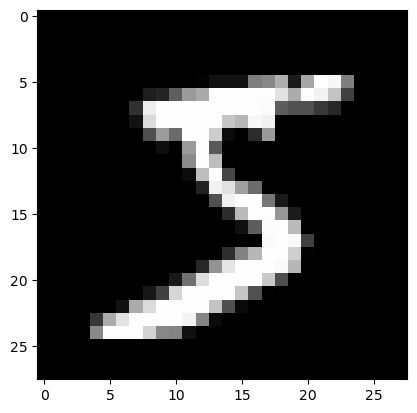

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(dataset[0][0], cmap="gray")

PyTorch doesn't know how to work with images. We need to convert the images into tensors. We can do this by specifying a transform while creating our dataset.

In [20]:
import torchvision.transforms as transforms

In [23]:
dataset = MNIST(root="data/",
                 train=True,
                   transform=transforms.ToTensor())

In [24]:
dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [25]:
img_tensor, label = dataset[0]

In [27]:
img_tensor.shape
# 1 channel as it is a graay scale image

torch.Size([1, 28, 28])

In [28]:
print(img_tensor[0,10:15,10:15])
print(torch.max(img_tensor), torch.min(img_tensor))

tensor([[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
        [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
        [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
        [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
        [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]])
tensor(1.) tensor(0.)


The values range from 0 to 1, with `0` representing black, `1` white, and the values in between different shades of grey. We can also plot the tensor as an image using `plt.imshow`.

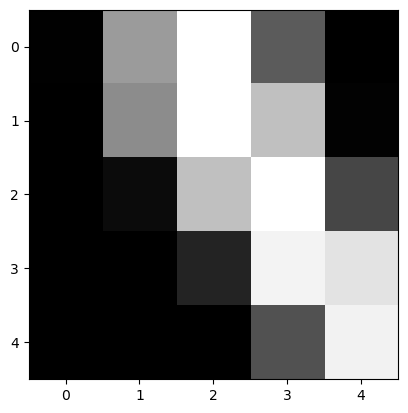

In [29]:
# Plot the image by passing in the 28x28 matrix
plt.imshow(img_tensor[0,10:15,10:15], cmap='gray');

## Training and Validation Datasets

While building real-world machine learning models, it is quite common to split the dataset into three parts:

1. **Training set** - used to train the model, i.e., compute the loss and adjust the model's weights using gradient descent.
2. **Validation set** - used to evaluate the model during training, adjust hyperparameters (learning rate, etc.), and pick the best version of the model.
3. **Test set** - used to compare different models or approaches and report the model's final accuracy.

In the MNIST dataset, there are 60,000 training images and 10,000 test images. The test set is standardized so that different researchers can report their models' results against the same collection of images. 

Since there's no predefined validation set, we must manually split the 60,000 images into training and validation datasets. Let's set aside 10,000 randomly chosen images for validation. We can do this using the `random_spilt` method from PyTorch.

In [30]:
from torch.utils.data import random_split

train_data, val_data = random_split(dataset=dataset,
                                    lengths=[50000, 10000])

In [32]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(dataset=train_data,
                          batch_size= batch_size,
                          shuffle=True)

val_loader = DataLoader(dataset=val_data,
                        shuffle=True,
                        batch_size= batch_size)

## Model

Now that we have prepared our data loaders, we can define our model.

* A **logistic regression** model is almost identical to a linear regression model. It contains weights and bias matrices, and the output is obtained using simple matrix operations (`pred = x @ w.t() + b`). 

* As we did with linear regression, we can use `nn.Linear` to create the model instead of manually creating and initializing the matrices.

* Since `nn.Linear` expects each training example to be a vector, each `1x28x28` image tensor is _flattened_ into a vector of size 784 `(28*28)` before being passed into the model. 

* The output for each image is a vector of size 10, with each element signifying the probability of a particular target label (i.e., 0 to 9). The predicted label for an image is simply the one with the highest probability.

In [33]:
import torch.nn as nn

In [34]:
model = nn.Linear(in_features=784,
                  out_features=10)

In [36]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.0058,  0.0208, -0.0331,  ..., -0.0110, -0.0235,  0.0246],
         [-0.0350, -0.0184,  0.0009,  ..., -0.0019,  0.0172, -0.0314],
         [-0.0314, -0.0044,  0.0163,  ...,  0.0077,  0.0309, -0.0114],
         ...,
         [ 0.0344, -0.0087,  0.0102,  ..., -0.0263,  0.0352,  0.0093],
         [-0.0223, -0.0096,  0.0012,  ..., -0.0066,  0.0206, -0.0243],
         [ 0.0312,  0.0124,  0.0207,  ...,  0.0345,  0.0019, -0.0102]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0011, -0.0305, -0.0208, -0.0209, -0.0198, -0.0122, -0.0270, -0.0120,
          0.0248, -0.0340], requires_grad=True)]

In [38]:
for images, labels in train_loader:
    print(labels)
    print(images.shape)
    break

## output (batch size * channel * height * width)

tensor([1, 1, 4, 7, 4, 7, 6, 6, 9, 5, 7, 4, 1, 1, 8, 7, 9, 7, 4, 2, 2, 3, 1, 0,
        1, 2, 2, 5, 1, 7, 1, 7, 4, 1, 1, 9, 5, 1, 6, 2, 9, 7, 3, 7, 4, 6, 9, 7,
        1, 5, 6, 0, 7, 6, 6, 2, 3, 4, 4, 4, 3, 4, 1, 9, 6, 5, 3, 4, 0, 0, 2, 4,
        3, 9, 1, 2, 9, 4, 4, 2, 3, 9, 0, 6, 6, 8, 3, 9, 5, 8, 0, 7, 4, 5, 7, 1,
        7, 9, 0, 9, 9, 1, 9, 6, 9, 6, 2, 6, 1, 4, 8, 4, 9, 3, 7, 8, 8, 2, 3, 9,
        0, 2, 3, 1, 1, 6, 9, 0])
torch.Size([128, 1, 28, 28])


In [40]:
for images, labels in train_loader:
    print(labels)
    print(images.shape)
    break

tensor([4, 2, 8, 7, 5, 0, 9, 0, 7, 8, 0, 3, 4, 3, 2, 2, 4, 2, 8, 4, 5, 4, 4, 7,
        3, 9, 0, 8, 0, 7, 7, 5, 9, 0, 8, 6, 6, 2, 9, 3, 7, 6, 0, 6, 9, 1, 3, 5,
        8, 7, 1, 8, 4, 7, 8, 9, 3, 9, 6, 9, 1, 0, 3, 1, 6, 7, 8, 7, 1, 8, 2, 5,
        1, 4, 2, 1, 7, 0, 0, 1, 1, 9, 9, 3, 7, 2, 5, 0, 2, 7, 8, 3, 4, 2, 9, 3,
        8, 5, 4, 1, 3, 0, 0, 6, 2, 8, 2, 8, 1, 5, 1, 5, 5, 6, 7, 8, 8, 9, 1, 1,
        3, 1, 3, 1, 0, 9, 3, 1])
torch.Size([128, 1, 28, 28])


xb.reshape(-1, 28*28) indicates to PyTorch that we want a view of the xb tensor with two dimensions. The length along the 2nd dimension is 28*28 (i.e., 784). One argument to .reshape can be set to -1 (in this case, the first dimension) to let PyTorch figure it out automatically based on the shape of the original tensor.

In [44]:
input_size = 784
num_classes = 10
class MNISTModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(in_features=input_size, 
                                out_features=num_classes)
    
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear()
        return out


In [47]:
mnist_model = MNISTModel()
list(mnist_model.parameters())

[Parameter containing:
 tensor([[ 0.0278,  0.0002,  0.0287,  ..., -0.0160, -0.0212,  0.0064],
         [ 0.0078,  0.0225,  0.0139,  ..., -0.0334,  0.0331, -0.0286],
         [ 0.0326,  0.0125, -0.0015,  ..., -0.0112,  0.0165,  0.0302],
         ...,
         [ 0.0055, -0.0130,  0.0123,  ..., -0.0223,  0.0264, -0.0240],
         [-0.0215, -0.0305,  0.0169,  ..., -0.0069,  0.0285,  0.0018],
         [ 0.0200, -0.0249, -0.0046,  ..., -0.0068,  0.0174,  0.0256]],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.0318, -0.0198,  0.0194, -0.0178, -0.0145, -0.0238, -0.0100,  0.0336,
          0.0137, -0.0238], requires_grad=True)]

In [58]:
for xb, yb in train_loader:
    output = mnist_model(xb)
    print(output)
    break

tensor([[ 0.4017,  0.2401,  0.1277,  ..., -0.1217, -0.0282, -0.0603],
        [ 0.0024,  0.0144,  0.1051,  ..., -0.1227, -0.0391,  0.1472],
        [-0.1454, -0.0415,  0.0535,  ...,  0.0957,  0.0768,  0.0210],
        ...,
        [ 0.2041,  0.0211,  0.0878,  ...,  0.0952,  0.1521,  0.2064],
        [ 0.0291,  0.0885, -0.0368,  ...,  0.2235, -0.0787,  0.0751],
        [-0.2338,  0.3154,  0.0648,  ...,  0.2675,  0.0842, -0.0238]],
       grad_fn=<AddmmBackward0>)


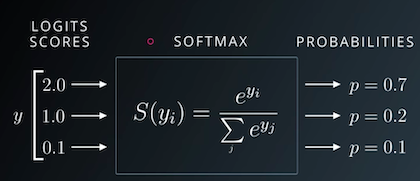

In [60]:
import torch.nn.functional as F

In [61]:
# Apply softmax for each output row
probs = F.softmax(output, dim=1)

In [62]:
max_probs, preds = torch.max(probs, dim=1)
print(preds)
print(max_probs)

tensor([0, 5, 7, 8, 2, 7, 7, 1, 0, 1, 0, 7, 2, 7, 5, 4, 0, 7, 0, 1, 1, 7, 0, 7,
        7, 2, 0, 4, 0, 1, 0, 5, 7, 1, 0, 7, 5, 2, 8, 2, 7, 0, 0, 7, 0, 2, 0, 0,
        2, 7, 9, 7, 9, 1, 4, 1, 7, 5, 2, 7, 0, 8, 8, 5, 7, 7, 1, 9, 4, 1, 2, 7,
        1, 9, 0, 5, 5, 2, 7, 7, 0, 2, 1, 7, 1, 7, 7, 7, 1, 7, 9, 1, 7, 3, 2, 1,
        7, 0, 1, 7, 2, 2, 0, 0, 7, 2, 8, 5, 2, 0, 8, 0, 7, 7, 1, 1, 0, 2, 0, 0,
        0, 0, 0, 1, 7, 9, 7, 1])
tensor([0.1502, 0.1327, 0.1094, 0.1250, 0.1285, 0.1212, 0.1511, 0.1241, 0.1354,
        0.1311, 0.1266, 0.1227, 0.1246, 0.1350, 0.1167, 0.1172, 0.1286, 0.1181,
        0.1197, 0.1162, 0.1292, 0.1403, 0.1459, 0.1228, 0.1388, 0.1218, 0.1179,
        0.1175, 0.1601, 0.1213, 0.1214, 0.1236, 0.1187, 0.1161, 0.1245, 0.1262,
        0.1132, 0.1305, 0.1288, 0.1168, 0.1175, 0.1443, 0.1467, 0.1248, 0.1221,
        0.1220, 0.1167, 0.1199, 0.1385, 0.1280, 0.1411, 0.1161, 0.1188, 0.1356,
        0.1216, 0.1323, 0.1193, 0.1347, 0.1213, 0.1329, 0.1198, 0.1108, 0.1160,
       

## Evaluation Metric and Loss Function

In [65]:
evals = torch.sum(preds == yb)

Accuracy is an excellent way for us (humans) to evaluate the model. However, we can't use it as a loss function for optimizing our model using gradient descent for the following reasons:

1. It's not a differentiable function. `torch.max` and `==` are both non-continuous and non-differentiable operations, so we can't use the accuracy for computing gradients w.r.t the weights and biases.

2. It doesn't take into account the actual probabilities predicted by the model, so it can't provide sufficient feedback for incremental improvements. 

For these reasons, accuracy is often used as an **evaluation metric** for classification, but not as a loss function. A commonly used loss function for classification problems is the **cross-entropy**, which has the following formula:

![cross-entropy](https://i.imgur.com/VDRDl1D.png)

While it looks complicated, it's actually quite simple:

* For each output row, pick the predicted probability for the correct label. E.g., if the predicted probabilities for an image are `[0.1, 0.3, 0.2, ...]` and the correct label is `1`, we pick the corresponding element `0.3` and ignore the rest.

* Then, take the [logarithm](https://en.wikipedia.org/wiki/Logarithm) of the picked probability. If the probability is high, i.e., close to 1, then its logarithm is a very small negative value, close to 0. And if the probability is low (close to 0), then the logarithm is a very large negative value. We also multiply the result by -1, which results is a large postive value of the loss for poor predictions.

![](https://www.intmath.com/blog/wp-content/images/2019/05/log10.png)

* Finally, take the average of the cross entropy across all the output rows to get the overall loss for a batch of data.

Unlike accuracy, cross-entropy is a continuous and differentiable function. It also provides useful feedback for incremental improvements in the model (a slightly higher probability for the correct label leads to a lower loss). These two factors make cross-entropy a better choice for the loss function.

As you might expect, PyTorch provides an efficient and tensor-friendly implementation of cross-entropy as part of the `torch.nn.functional` package. Moreover, it also performs softmax internally, so we can directly pass in the model's outputs without converting them into probabilities.